<a href="https://colab.research.google.com/github/adiojha629/HaltConv/blob/main/Halt_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [43]:
import torch #Pytorch used for Model creation
import torchvision
from torchvision import datasets, transforms # 'datasets' gives us MNIST, 'transforms' allows use to turn images into tensors
import matplotlib.pyplot as plt #To View Images
import torch.nn as nn #To set up the model
import torch.nn.functional as F #To calculate loss, use different activations etc.
import torch.optim as optim #To access the adam optimizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import csv
import torch.optim as optim
from operator import add,truediv
from sys import getsizeof

In [44]:
if False:
  vanilla_fl_dict = {'Server': [[1.791189040851593, 0.3603], [1.0364729088753462, 0.6331], [0.8723062273774296, 0.6967], [0.8009874275865033, 0.7247], [0.7405818013698329, 0.748], [0.695321643771138, 0.7635], [0.6611248622483574, 0.7776], [0.6337108630706091, 0.7858], [0.6418373847729526, 0.7834], [0.5955128319623647, 0.7997]]}
  test_accuracy = [vanilla_fl_dict['Server'][i][1] for i in range(len(vanilla_fl_dict['Server']))]
  test_loss = [vanilla_fl_dict['Server'][i][0] for i in range(len(vanilla_fl_dict['Server']))]

  fig,ax = plt.subplots(1,2,figsize=(12,6))
  ax[0].plot(test_accuracy,'b')
  ax[0].set_title("Global Accuracy vs. Communication Round")
  ax[0].set_xlabel("Communication Round")
  ax[0].set_ylabel("Accuracy")
  ax[1].plot(test_loss,'g')
  ax[1].set_title("Global Loss vs. Communication Round")
  ax[1].set_xlabel("Communication Round")
  ax[1].set_ylabel("Neg. Log Likihood Loss")
  fig.show()
  fig.savefig("Vanilla_FL.png")

# Load Cifar-10 and practice training

Cifar loading code borrowed from:<br>
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


In [45]:
print("Load Cifar and practice training")
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
num_devices = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, # for server
                                          shuffle=True, num_workers=2)
#from : https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029
# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(trainset, [int(trainset.data.shape[0] / num_devices) for _ in range(num_devices)])
#^ for clients

# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Load Cifar and practice training
Files already downloaded and verified
Files already downloaded and verified


# Halt Dense Simulation
during each model update <br>
if accuracy > threshold:<br>
> share convolutional and dense layers
<br>else:<br>
> share convolutional layers only

## Classes needed



In [4]:
# Super-class model
# Now use setup from FedMax
Allen_Net = {'Conv': [32,'M',64,64,'M',64,64,'M'],
             'MLP': [(1024,512),'ReLU',(512,10)]} # 'MLP' for user-readability, not used to generate dense layers

class Model(nn.Module):
  def __init__(self,net_setup):
    super().__init__()
    self.ConvLayers = self._make_conv(net_setup['Conv'])
    self.MLP = nn.Sequential(nn.Linear(1024,512),nn.ReLU(True),nn.Linear(512,10))
    self.criterion = nn.CrossEntropyLoss()
    self.optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
  def _make_conv(self,layer_list):
    layer = [] # add layers based on layer_list
    in_channel = 3 # starting in_channel
    for x in layer_list:
      if x == 'M':# Add maxpool2d
        layer += [nn.MaxPool2d(kernel_size = 2,stride = 2)]
      else:
        layer += [nn.Conv2d(in_channel,x,kernel_size = 3,padding=1),nn.BatchNorm2d(x),nn.ReLU(inplace=True)]
        in_channel = x # set new channel size
    return nn.Sequential(*layer) # make layers into sequential object
  def forward(self,x):
    out1 = self.ConvLayers(x) # conv
    out2 = out1.view(out1.size(0),-1) # flatten
    out3 = self.MLP(out2) # mlp
    return F.log_softmax(out3,dim=1) # log softmax activation 
  def getConvWeights(self):
    return self.ConvLayers.state_dict()
  def getDenseWeights(self):
    return self.MLP.state_dict()
  def setConvWeights(self,conv_state_dict):
    self.ConvLayers.load_state_dict(conv_state_dict)

  def setDenseWeights(self,dense_state_dict):
    self.MLP.load_state_dict(dense_state_dict)

def train(model,dataloader,epochs):
  model.train()
  running_loss = 0.0
  for epoch in range(epochs):
    for i,data in enumerate(dataloader):
      inputs,labels = data
      model.optimizer.zero_grad()
      outputs = model.forward(inputs)
      loss = model.criterion(outputs,labels)
      running_loss += float(loss)
      loss.backward()
      model.optimizer.step()
  return running_loss/len(dataloader.dataset)

#Testing functions
def test(model,testloader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data,target in testloader:
      #data,target = data.cuda(),target.cuda()
      output = model(data)
      test_loss += F.nll_loss(output,target,reduction='sum').item()
      pred = output.argmax(dim=1,keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(testloader.dataset)
  acc = correct/len(testloader.dataset)
  return test_loss,acc

## Debug Model Class

In [ ]:
batch = 23
color_channels = 3
img_size = 32
x = torch.randn(batch,color_channels,img_size,img_size)
server = Model(Allen_Net)
#server(x) # it works! May 29th 4:54pm
x = server.getConvWeights()
#x[0].size()
y = server.getDenseWeights()
#y[0].size() # should be 128x128

device1 = Model(Allen_Net) # test of setConvWeights
x = server.getConvWeights()
print(id(x))
device1.setConvWeights(server.getConvWeights())
y = device1.getConvWeights()
print(id(y))
for i,j in zip(x,y):
  assert id(x) != id(y) # shouldn't be at the same address 

device1 = Model(Allen_Net) # test of setConvWeights
x = server.getDenseWeights()
print(id(x))
device1.setDenseWeights(server.getDenseWeights())
y = device1.getDenseWeights()
print(id(y))
for i,j in zip(x,y):
  assert id(x) != id(y) # shouldn't be at the same address 

print(getsizeof(server.getDenseWeights()))
print(getsizeof(server.getConvWeights()))
print("Passed prelim tests")

139757298336832
139757298336112
139757298335824
139757298336688
504
2888
Passed prelim tests


# Vanilla FL

In [ ]:
def Vanilla_FL(num_devices=4,communication_rounds = 10,epoches = 1,train_loader,testloader)
  print("Set up devices for vanilla FL")
  results_dict = dict()
  results_dict['Bytes Sent'] = 0
  #num_devices = num_clients
  for i in range(num_devices):
    results_dict["Device "+str(i)] = []
  results_dict["Server"] = []
  #communication_rounds = 10
  #epoches = 1
  devices = []
  for i in range(num_devices): # init devices and server
    devices.append(Model(Allen_Net))
  server = Model(Allen_Net)

  for i in range(communication_rounds): # training loop
    print("Starting Communication Round %d"%(i))
    print("Transfer Global Model to devices")
    for device in devices:
      device.setConvWeights(server.getConvWeights())
      device.setDenseWeights(server.getDenseWeights())

    print("Training each device")
    for i,device in enumerate(devices):
      loss = train(device,train_loader[i],epoches)
      test_l,acc = test(device,train_loader[i])
      results_dict["Device "+str(i)].append([loss,test_l,acc])
      print("Device %d has training loss %f, testing loss %f, acc %f"%(i,loss,test_l,acc))
    
    print("Aggregate device models to server")
    global_dict = server.state_dict()
    for k in global_dict.keys():
      results_dict['Bytes Sent'] += getsizeof([devices[i].state_dict()[k].float() for i in range(num_devices)])
      print("Total bytes sent so far %d"%(results_dict['Bytes Sent']))
      global_dict[k] = torch.stack([devices[i].state_dict()[k].float() for i in range(num_devices)],0).mean(0)
    server.load_state_dict(global_dict)

    # test server
    test_loss,acc = test(server,testloader)
    print("Server Accuracy %f, test loss %f"%(acc,test_loss))
    results_dict["Server"].append([test_loss,acc])
  print("Results Dict")
  print(results_dict)
  return results_dict

Set up devices for vanilla FL
Starting Communication Round 0
Transfer Global Model to devices
Training each device


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Device 0 has training loss 5145.231034, testing loss 1.207862, acc 0.553040
Device 1 has training loss 5077.636754, testing loss 1.261184, acc 0.534400
Device 2 has training loss 5073.832818, testing loss 1.268007, acc 0.547040
Device 3 has training loss 5113.694790, testing loss 1.337343, acc 0.525840
Aggregate device models to server
Total bytes sent so far 104
Total bytes sent so far 208
Total bytes sent so far 312
Total bytes sent so far 416
Total bytes sent so far 520
Total bytes sent so far 624
Total bytes sent so far 728
Total bytes sent so far 832
Total bytes sent so far 936
Total bytes sent so far 1040
Total bytes sent so far 1144
Total bytes sent so far 1248
Total bytes sent so far 1352
Total bytes sent so far 1456
Total bytes sent so far 1560
Total bytes sent so far 1664
Total bytes sent so far 1768
Total bytes sent so far 1872
Total bytes sent so far 1976
Total bytes sent so far 2080
Total bytes sent so far 2184
Total bytes sent so far 2288
Total bytes sent so far 2392
Tota

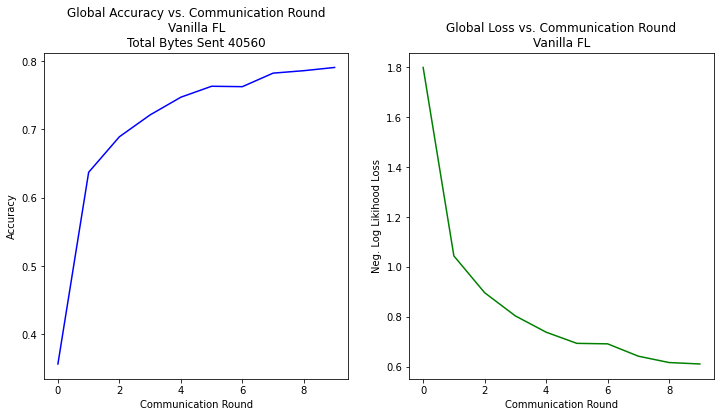

In [ ]:
# Visualize results
test_accuracy = [results_dict['Server'][i][1] for i in range(len(results_dict['Server']))]
test_loss = [results_dict['Server'][i][0] for i in range(len(results_dict['Server']))]

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(test_accuracy,'b')
ax[0].set_title("Global Accuracy vs. Communication Round\nVanilla FL\nTotal Bytes Sent %d"%(results_dict['Bytes Sent']))
ax[0].set_xlabel("Communication Round")
ax[0].set_ylabel("Accuracy")
ax[1].plot(test_loss,'g')
ax[1].set_title("Global Loss vs. Communication Round\nVanilla FL")
ax[1].set_xlabel("Communication Round")
ax[1].set_ylabel("Neg. Log Likihood Loss")
fig.show()
fig.savefig("Vanilla_FL.png")

# Halt

In [69]:
def Halt_FL(train_loader,testloader,num_devices = 4,communication_rounds = 10,epoches = 1,alpha=0.80):
  print("Set up devices for Halt- FL")
  #alpha = 0.75
  results_dict = dict()
  results_dict['Bytes Sent'] = 0
  #num_devices = 4
  for i in range(num_devices):
    results_dict["Device "+str(i)] = []
  results_dict["Server"] = []
  #communication_rounds = 10
  #epoches = 1
  devices = []
  for i in range(num_devices): # set up each device and server model
    devices.append(Model(Allen_Net))
  server = Model(Allen_Net)

  for i in range(communication_rounds):
    print("Starting Communication Round %d"%(i))
    print("Transfer Global Model to devices")
    for device in devices:
      device.setConvWeights(server.getConvWeights())
      device.setDenseWeights(server.getDenseWeights())

    print("Training each device")
    dense_index = []
    for i,device in enumerate(devices):
      loss = train(device,train_loader[i],epoches)
      test_l,acc = test(device,train_loader[i])
      if acc > alpha:### need to check with alpha threshold
        dense_index.append(i)
      results_dict["Device "+str(i)].append([loss,test_l,acc])
      print("Device %d has training loss %f, testing loss %f, acc %f"%(i,loss,test_l,acc))
    
    print("Aggregate device models to server.%d devices met threshold"%(len(dense_index)))
    #global_dict = server.state_dict()
    global_conv = server.getConvWeights()
    global_dense = server.getDenseWeights()
    for k in global_conv.keys():
      results_dict['Bytes Sent'] += getsizeof([devices[i].getConvWeights()[k].float() for i in range(num_devices)])
      global_conv[k] = torch.stack([devices[i].getConvWeights()[k].float() for i in range(num_devices)],0).mean(0)
    if len(dense_index) > 0: # if any device met threshold
      for k in global_dense.keys():
        results_dict['Bytes Sent'] += getsizeof([devices[i].getDenseWeights()[k].float() for i in dense_index])
        global_dense[k] = torch.stack([devices[i].getDenseWeights()[k].float() for i in dense_index],0).mean(0)
    #server.load_state_dict(global_dict)
    server.setConvWeights(global_conv)
    server.setDenseWeights(global_dense)
    
    # test server
    test_loss,acc = test(server,testloader)
    print("Server Accuracy %f, test loss %f\n%d bytes sent"%(acc,test_loss,results_dict['Bytes Sent']))
    results_dict["Server"].append([test_loss,acc])
  print("Results Dict")
  print(results_dict)
  return results_dict

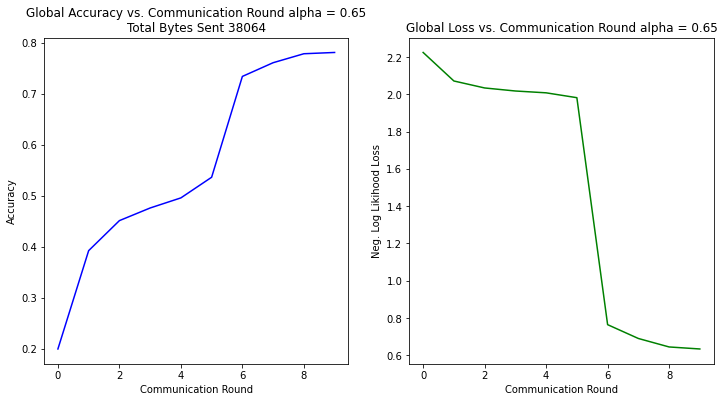

In [ ]:
# visualize results
test_accuracy = [results_dict['Server'][i][1] for i in range(len(results_dict['Server']))]
test_loss = [results_dict['Server'][i][0] for i in range(len(results_dict['Server']))]

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].plot(test_accuracy,'b')
ax[0].set_title("Global Accuracy vs. Communication Round alpha = 0.65\nTotal Bytes Sent %d"%(results_dict['Bytes Sent']))
ax[0].set_xlabel("Communication Round")
ax[0].set_ylabel("Accuracy")
ax[1].plot(test_loss,'g')
ax[1].set_title("Global Loss vs. Communication Round alpha = 0.65")
ax[1].set_xlabel("Communication Round")
ax[1].set_ylabel("Neg. Log Likihood Loss")
fig.show()
fig.savefig("Halt_FL_alpha=.65.png")

# Non-IID Dataloaders


In [ ]:
# look here: https://github.com/AshwinRJ/Federated-Learning-PyTorch/blob/master/src/sampling.py

In [46]:
import numpy as np
from torchvision import datasets, transforms
def get_labels(dataset):
  """
  Get numpy array of labels from torchvision datasets object
  :param: dataset- the torchvision dataset object to extract labels from
  :return: np.array of all labels
  """
  size = dataset.__len__()
  labels = []
  for i in range(size):
    img,label = dataset.__getitem__(i)
    labels.append(label)
  return np.array(labels)
def cifar_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    num_shards, num_imgs = 200, 250
    idx_shard = [i for i in range(num_shards)] # 0,1,2,...199
    dict_users = {i: np.array([]) for i in range(num_users)} # dictionary of users
    idxs = np.arange(num_shards*num_imgs) # 0,1,2, .... 49,999 : 50,000 length
    #labels = dataset.train_labels.numpy()
    #labels = np.array(dataset.train_labels) old way not work
    labels = get_labels(dataset) # Length 50,000

    # sort labels
    idxs_labels = np.vstack((idxs, labels)) # [[0-49,999],[label1-label50,000]]
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()] # sort labels 
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, 2, replace=False)) #sample 2 ids without replacement
        idx_shard = list(set(idx_shard) - rand_set) # remove those 2 ids from idx_shard so they can't be choosen again
        for rand in rand_set: # For each id, we choose one user, (b/c logic above we choose each user once)
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0) # add one index
            ## returns a dict where each user is a key, and the values are arrays of indices to specific images
    for user in dict_users.keys():
      id_array = dict_users[user].copy()
      img_list = []
      label_list = []
      #print(id_array)
      #adi = input()
      for id in id_array:
        img,label = dataset.__getitem__(int(id))
        img_list.append(img)
        label_list.append(label)
      dict_users[user] = [img_list,label_list]
    return dict_users # returns a dict where each user is a key, and 
    #the values is a list of 2 lists: one with images in order, other with corresponding labels

In [47]:
x = cifar_noniid(trainset,10)
#to check that all 10 classes are present
labels = set()
for key in x.keys():
  labels = labels | set(x[key][1])
print(labels)
print(x.keys())
# keys - index for each device
# values - ndarray of

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [76]:
# Define Dataset class for non-iid sets
from torch.utils.data import Dataset, DataLoader
class non_iid_dataset(Dataset):
  def __init__(self,img_list,label_list,transform=None):
    super().__init__()
    self.imgs = torch.stack(img_list)
    self.labels = np.array(label_list)
    self.transform = transform
  def __len__(self):
    return len(self.labels)
  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.imgs[idx]
        label = self.labels[idx]
        sample = {'image': img, 'landmarks': label}
        if self.transform:
          sample = self.transform(sample)
  def __iter__(self):
    return non_iid_iteratorClass(self)
class non_iid_iteratorClass:
  def __init__(self,data):
    self._data = data
    self._index = 0
  def __next__(self):
    if self._index < _data.__len__():
      result = self._data.__getitem__(self._index)
      self._index+=1
      return result
    else:
      raise StopIteration

In [77]:
# create Dataloaders for non-iid data
batch_size = 4
num_devices = 4
#non_iid_data = cifar_noniid(trainset,num_devices)
transformer = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
non_iid_train_split = [non_iid_dataset(img_list = non_iid_data[key][0],
                                       label_list = non_iid_data[key][1],
                                       transform = transformer) for key in non_iid_data.keys()]
train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in non_iid_train_split]
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Files already downloaded and verified


In [78]:
Halt_FL(train_loader=train_loader,testloader=testloader,num_devices = 4,communication_rounds = 10,epoches = 1,alpha=0.80)

Set up devices for Halt- FL
Starting Communication Round 0
Transfer Global Model to devices
Training each device


TypeError: ignored

# Debug

In [ ]:
# to continue training: old needs to be changined for iid data: june 11th
for i in range(3,10):
  print("Starting Communication Round %d"%(i))
  print("Transfer Global Model to devices")
  for device in devices:
    device.setConvWeights(server)
    device.setDenseWeights(server)

  print("Training each device")
  for i,device in enumerate(devices):
    accuracy = device.train(trainloader,epoches)
    results_dict["Device "+str(i)].append(accuracy)
    print("Device %d has accuracy %f"%(i,accuracy))
  
  print("Aggregate device models to server")
  global_conv = []
  global_dense = []
  for device in devices:
    global_conv.append(device.getConvWeights())
    global_dense.append(device.getDenseWeights())
  x = global_conv[0]
  y = global_dense[0]
  for idx in range(1,num_devices,1):#from index 1 to the end
    x = list(map(add,x,global_conv[idx]))
    y = list(map(add,y,global_dense[idx]))
  x = [torch.div(conv,num_devices) for conv in x]
  y = [torch.div(dense,num_devices) for dense in y]
  server.set_weights(x,y)
  accuracy = server.train(trainloader,epoches)
  results_dict["Server"].append(accuracy)
print("Results Dict")
print(results_dict)

Starting Communication Round 3
Transfer Global Model to devices
Training each device


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

Device 0 has accuracy 0.101000
Device 1 has accuracy 0.100000
Device 2 has accuracy 0.100000
Device 3 has accuracy 0.100000
Aggregate device models to server


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().req

Starting Communication Round 4
Transfer Global Model to devices
Training each device
Device 0 has accuracy 0.285720
Device 1 has accuracy 0.100000
Device 2 has accuracy 0.100000
Device 3 has accuracy 0.170760
Aggregate device models to server
Starting Communication Round 5
Transfer Global Model to devices
Training each device
Device 0 has accuracy 0.340680
Device 1 has accuracy 0.232540
Device 2 has accuracy 0.100060
Device 3 has accuracy 0.321460
Aggregate device models to server
Starting Communication Round 6
Transfer Global Model to devices
Training each device
Device 0 has accuracy 0.374020
Device 1 has accuracy 0.306640
Device 2 has accuracy 0.234840


In [ ]:
print("Results Dict")
print(results_dict)

In [ ]:
# check aggregation
global_conv = []
global_dense = []
for device in devices:
  global_conv.append(device.getConvWeights())
  global_dense.append(device.getDenseWeights())
#print(global_conv)
x = global_conv[0]
y = global_dense[0]
#print(x[0][0])
for idx in range(1,num_devices,1):
  print(idx)
  x = list(map(add,x,global_conv[idx]))
  y = list(map(add,y,global_dense[idx]))
print(x[0][0])
adi = input("continue")
x = [torch.div(conv,num_devices) for conv in x]
y = [torch.div(dense,num_devices) for dense in y]
print(x[0][0])
# it works

In [ ]:
print(global_conv[0][0][0])
print(global_conv[1][0][0])
print(global_conv[2][0][0])

In [ ]:
len(global_conv)
print(range(2,num_devices,1))


In [ ]:
server.train(trainloader,epoches)

In [ ]:
a = torch.randn(4, 4)
b = torch.randn(4, 4)
torch.mean(Tensor(a,b))